In [3]:
# prompt: ignore warnings

import warnings
warnings.filterwarnings('ignore')



# Load Data for Undersampling

In [5]:
import pandas as pd
df = pd.read_csv("carsh_mod_grouped.csv")
df

,COUNTY,LIGHT,WEATHER,ROAD_COND,SURFACE_COND,RELATION_TO_JUNCTI,INTER_TYPE,MANNER_OF_COLL,ROAD_GEOM,LATITUDE,...,OP_AGE_D1,OP_SEX_D1,ALCOHOL_DRUG_DESCR_D1,CONTRIB_FACT_DESCR_D1,SPEED_LIMIT_D1,OP_AGE_D2,OP_SEX_D2,SPEED_LIMIT_D2,CRASH_HOUR,CRASH_SEVERITY
0,8,1,1,1,2.0,2,3,10,1,46.805305,...,0,1,0,6,0,2,0,0,0,5
1,45,2,2,1,2.0,2,3,2,1,46.905032,...,0,1,0,7,1,3,1,1,3,3
2,18,1,1,1,2.0,2,3,10,1,47.903942,...,1,0,0,6,0,0,0,0,0,3
3,9,2,1,1,1.0,1,1,2,1,46.861906,...,0,0,0,0,1,1,1,1,0,3
4,9,1,1,1,2.0,2,1,2,1,46.872620,...,0,1,0,5,1,1,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7359,9,1,1,1,2.0,2,1,1,2,46.818487,...,0,0,0,7,0,2,0,0,2,3
7360,45,1,1,1,1.0,1,1,2,1,46.879130,...,0,0,0,5,0,3,0,0,2,3
7361,53,2,1,1,1.0,2,3,1,1,48.160163,...,0,0,0,2,1,2,0,1,0,3
7362,51,1,1,1,2.0,2,1,1,1,48.221896,...,0,0,0,6,0,0,1,1,3,3


In [6]:
df.shape

(7364, 28)

## Severity Mapping

In [8]:
# Define the mapping for CRASH_SEVERITY categories
severity_mapping = {
    3: 1,  # Change category 3 to 1
    2: 2,  # Keep category 2 the same
    4: 3,  # Change category 4 to 3
    5: 3,  # Change category 5 to 3
    1: 4   # Change category 1 to 5
}

# Apply the mapping to the CRASH_SEVERITY column
df['CRASH_SEVERITY'] = df['CRASH_SEVERITY'].map(severity_mapping)

# Verify the changes
print(df['CRASH_SEVERITY'].value_counts())


CRASH_SEVERITY
1    5772
3    1034
2     551
4       7
Name: count, dtype: int64


In [9]:
# Define the mapping for CRASH_SEVERITY categories
severity_mapping = {
    3: 1,  # Change category 3 to 1
    2: 1,  # Keep category 2 the same
    4: 1,  # Change category 4 to 3
    1: 0   # Change category 1 to 5
}

# Apply the mapping to the CRASH_SEVERITY column
df['CRASH_SEVERITY'] = df['CRASH_SEVERITY'].map(severity_mapping)

# Verify the changes
print(df['CRASH_SEVERITY'].value_counts())


CRASH_SEVERITY
0    5772
1    1592
Name: count, dtype: int64


## Downsampling

In [11]:
from sklearn.utils import resample

# Get the minimum number of rows in any class
min_class_size = df['CRASH_SEVERITY'].value_counts().min()

# Perform undersampling
balanced_df = df.groupby('CRASH_SEVERITY', group_keys=False).apply(lambda x: x.sample(min_class_size, random_state=42))

# Verify the changes
print(balanced_df['CRASH_SEVERITY'].value_counts())

balanced_df.shape


CRASH_SEVERITY
0    1592
1    1592
Name: count, dtype: int64


(3184, 28)

In [12]:
df = balanced_df.copy()

In [13]:
X = df.drop(columns=['CRASH_SEVERITY'])
y = df['CRASH_SEVERITY']

In [14]:
y

538     0
2833    0
5208    0
2734    0
6828    0
       ..
5433    1
6120    1
4136    1
6829    1
5420    1
Name: CRASH_SEVERITY, Length: 3184, dtype: int64

## Tuned ML

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

### LR

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.60      0.59      0.60       319
           1       0.60      0.60      0.60       318

    accuracy                           0.60       637
   macro avg       0.60      0.60      0.60       637
weighted avg       0.60      0.60      0.60       637



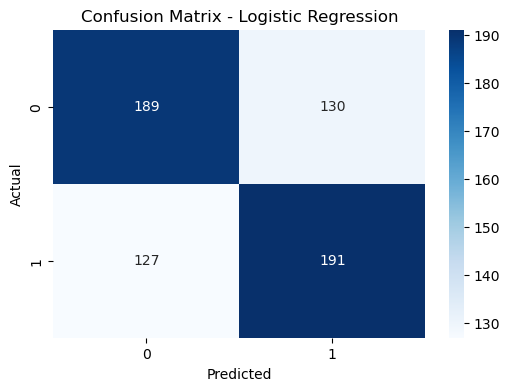

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Define hyperparameter grid
lr_params = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'lbfgs']
}

# Initialize model
lr = LogisticRegression(max_iter=5000, random_state=42)

# Perform Randomized Search CV
lr_search = RandomizedSearchCV(lr, lr_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
lr_search.fit(X_train, y_train)

# Best model
best_lr = lr_search.best_estimator_

# Predictions
y_pred_lr = best_lr.predict(X_test)

# Evaluate
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


ROC AUC Score: 0.62


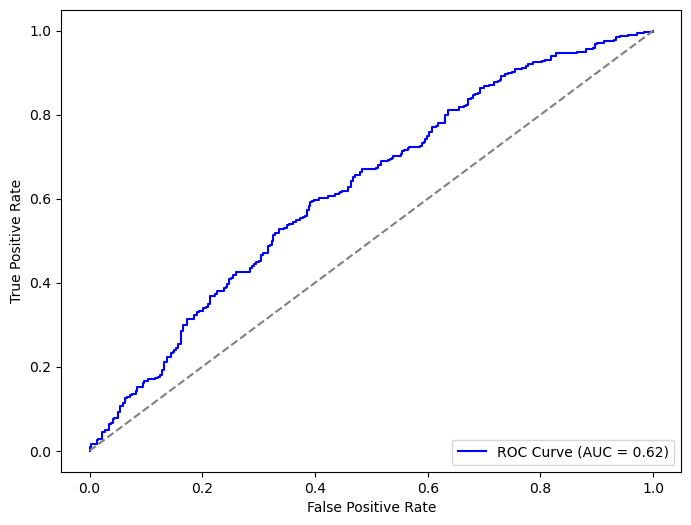

In [19]:

from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### RF

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       319
           1       0.60      0.62      0.61       318

    accuracy                           0.60       637
   macro avg       0.60      0.60      0.60       637
weighted avg       0.60      0.60      0.60       637



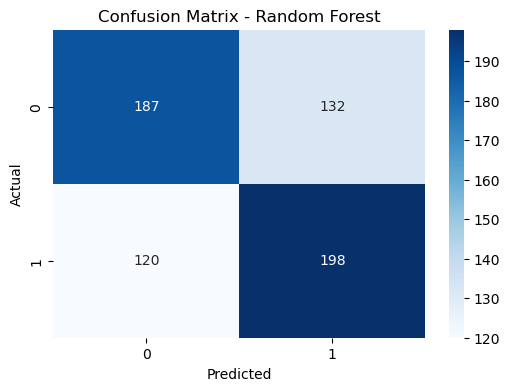

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid
rf_params = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Perform Randomized Search CV
rf_search = RandomizedSearchCV(rf, rf_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

# Best model
best_rf = rf_search.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test)

# Evaluate
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


ROC AUC Score: 0.64


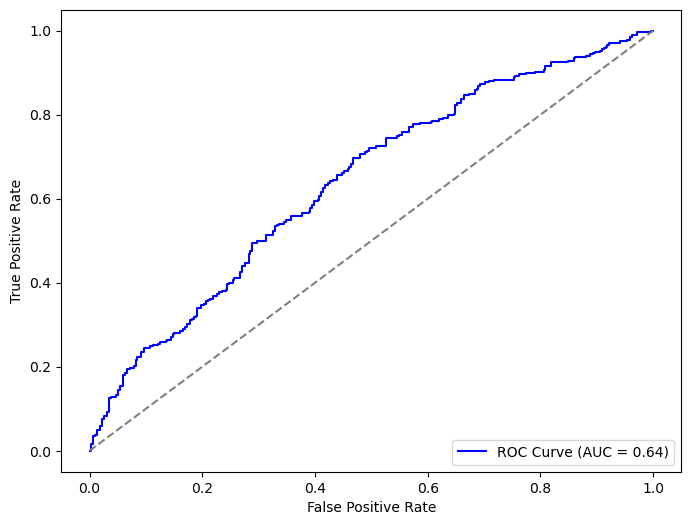

In [22]:

from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class
y_prob_lr = best_rf.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### MLP

MLP Performance:
              precision    recall  f1-score   support

           0       0.57      0.70      0.63       319
           1       0.61      0.47      0.53       318

    accuracy                           0.58       637
   macro avg       0.59      0.58      0.58       637
weighted avg       0.59      0.58      0.58       637



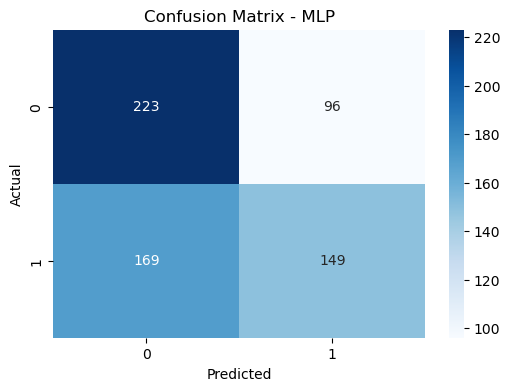

In [24]:
from sklearn.neural_network import MLPClassifier

# Define hyperparameter grid
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Initialize model
mlp = MLPClassifier(max_iter=1000, random_state=42)

# Perform Randomized Search CV
mlp_search = RandomizedSearchCV(mlp, mlp_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
mlp_search.fit(X_train, y_train)

# Best model
best_mlp = mlp_search.best_estimator_

# Predictions
y_pred_mlp = best_mlp.predict(X_test)

# Evaluate
print("MLP Performance:")
print(classification_report(y_test, y_pred_mlp))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MLP")
plt.show()


ROC AUC Score: 0.64


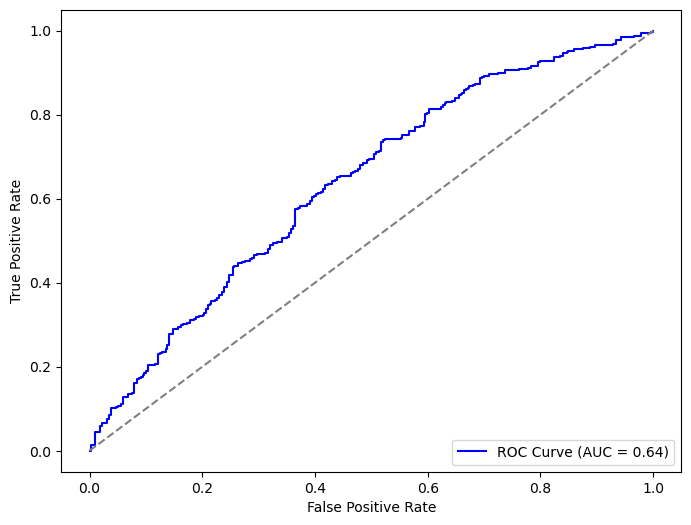

In [25]:

from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class
y_prob_lr = best_mlp.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### GB

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.60      0.61      0.60       319
           1       0.60      0.60      0.60       318

    accuracy                           0.60       637
   macro avg       0.60      0.60      0.60       637
weighted avg       0.60      0.60      0.60       637



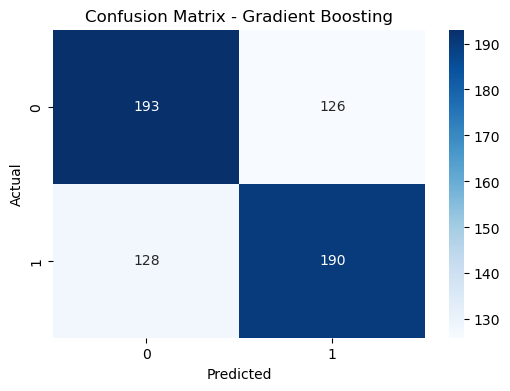

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

# Define hyperparameter grid
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

# Initialize model
gb = GradientBoostingClassifier(random_state=42)

# Perform Randomized Search CV
gb_search = RandomizedSearchCV(gb, gb_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
gb_search.fit(X_train, y_train)

# Best model
best_gb = gb_search.best_estimator_

# Predictions
y_pred_gb = best_gb.predict(X_test)

# Evaluate
print("Gradient Boosting Performance:")
print(classification_report(y_test, y_pred_gb))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


ROC AUC Score: 0.65


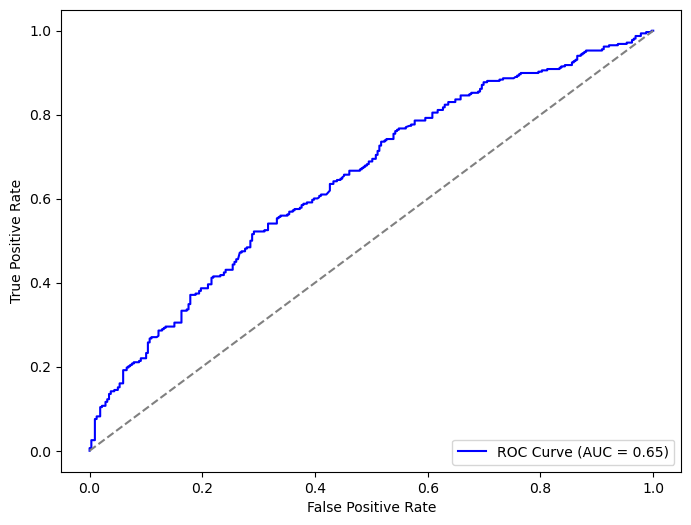

In [28]:

from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class
y_prob_lr = best_gb.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### KNN

KNN Performance:
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       319
           1       0.55      0.59      0.57       318

    accuracy                           0.55       637
   macro avg       0.55      0.55      0.55       637
weighted avg       0.55      0.55      0.55       637



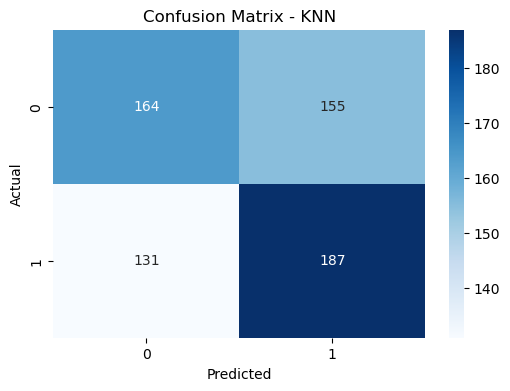

In [30]:
from sklearn.neighbors import KNeighborsClassifier

# Define hyperparameter grid
knn_params = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize model
knn = KNeighborsClassifier()

# Perform Randomized Search CV
knn_search = RandomizedSearchCV(knn, knn_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
knn_search.fit(X_train, y_train)

# Best model
best_knn = knn_search.best_estimator_

# Predictions
y_pred_knn = best_knn.predict(X_test)

# Evaluate
print("KNN Performance:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN")
plt.show()


ROC AUC Score: 0.57


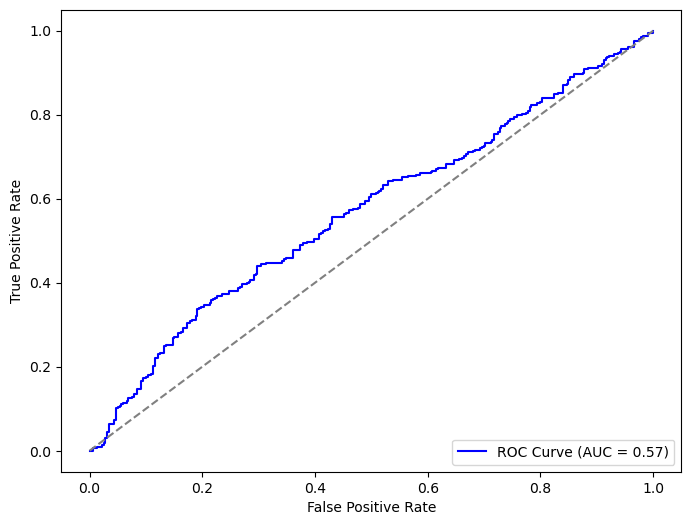

In [31]:

from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class
y_prob_lr = best_knn.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### Paramteres

In [33]:
print("Best Parameters for Logistic Regression:", lr_search.best_params_)
print("Best Parameters for Random Forest:", rf_search.best_params_)
print("Best Parameters for MLP:", mlp_search.best_params_)
print("Best Parameters for Gradient Boosting:", gb_search.best_params_)
print("Best Parameters for KNN:", knn_search.best_params_)


Best Parameters for Logistic Regression: {'solver': 'liblinear', 'C': 0.03359818286283781}
Best Parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Best Parameters for MLP: {'solver': 'adam', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}
Best Parameters for Gradient Boosting: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
Best Parameters for KNN: {'weights': 'distance', 'n_neighbors': 16, 'metric': 'euclidean'}


## Hybrid




Combination 66
Base Models: gradient_boosting, mlp
Meta Model: logistic
Accuracy: 0.6044
F1-score: 0.6050
ROC AUC: 0.6517

Detailed Classification Report:
              precision    recall  f1-score     support
0              0.605678  0.601881  0.603774  319.000000
1              0.603125  0.606918  0.605016  318.000000
accuracy       0.604396  0.604396  0.604396    0.604396
macro avg      0.604402  0.604400  0.604395  637.000000
weighted avg   0.604404  0.604396  0.604394  637.000000



Combination 96
Base Models: logistic, gradient_boosting, mlp
Meta Model: logistic
Accuracy: 0.6122
F1-score: 0.6098
ROC AUC: 0.6499

Detailed Classification Report:
              precision    recall  f1-score     support
0              0.611801  0.617555  0.614665  319.000000
1              0.612698  0.606918  0.609795  318.000000
accuracy       0.612245  0.612245  0.612245    0.612245
macro avg      0.612250  0.612237  0.612230  637.000000
weighted avg   0.612249  0.612245  0.612233  637.000000



C

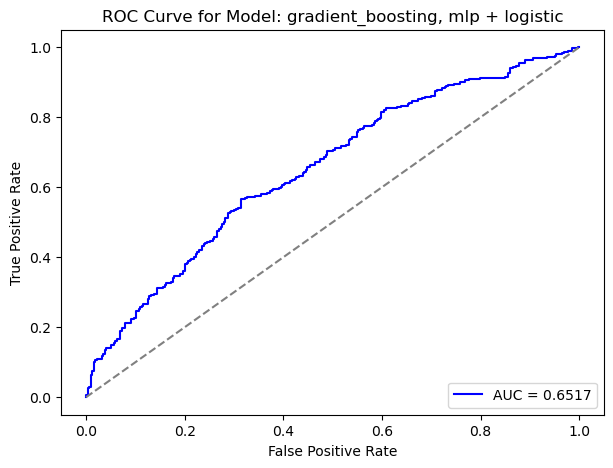

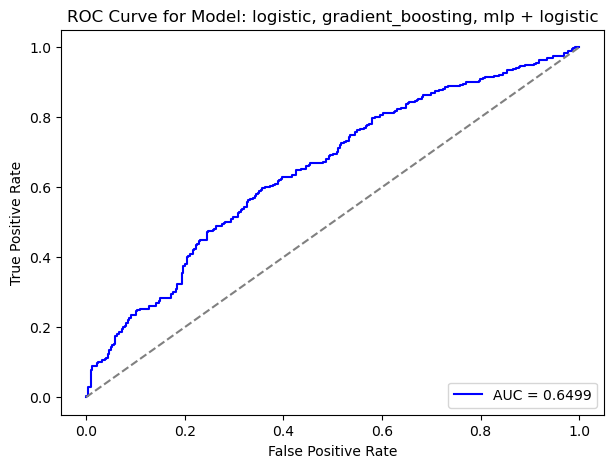

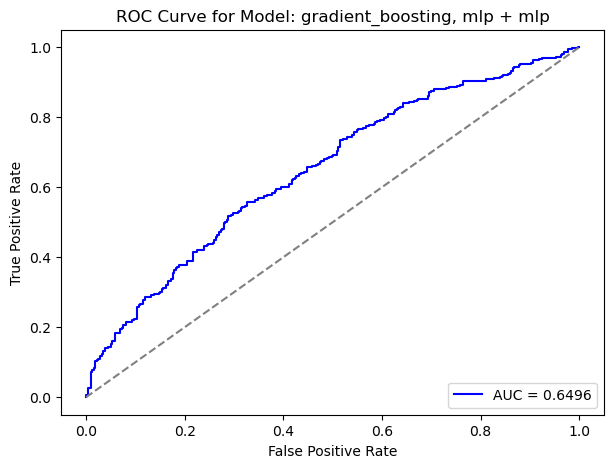

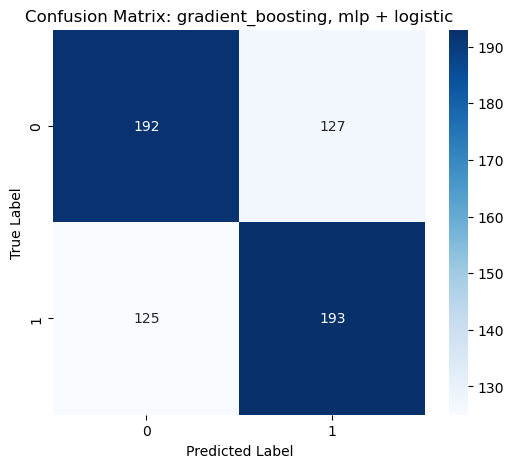

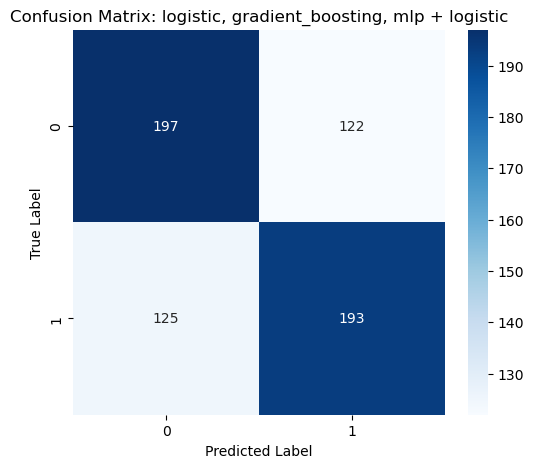

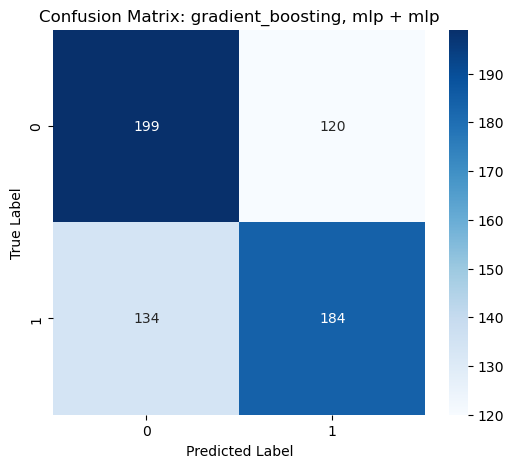

In [35]:
import sys
sys.path.append('/Code and Models')

from stacking_combination2 import BinaryStackingClassifierExperiment

# Suppose you already have your trained base models and meta models:
trained_models = {
    'logistic': best_lr,
    'random_forest': best_rf,
    'gradient_boosting': best_gb,
    'knn': best_knn,
    'mlp': best_mlp
}

meta_models = {
    'logistic': LogisticRegression(max_iter=5000, random_state=42),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'rf': RandomForestClassifier(n_estimators=100, random_state=42),
    'gb': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'mlp': MLPClassifier(hidden_layer_sizes=(100,), max_iter=5000, random_state=42)
}



experiment = BinaryStackingClassifierExperiment(trained_models, meta_models, verbose=False)



# Run your experiment
results_df = experiment.run_experiment(X_train, y_train, X_test, y_test)


# experiment.plot_top_results(top_n=5)
experiment.print_detailed_results(top_n=3)
experiment.plot_individual_roc_curves (top_n=3)
# Plot Confusion Matrices for top 3 models
experiment.plot_individual_confusion_matrices(top_n=3)

## ANN

Model loaded successfully!
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy: 0.7834
ROC AUC Score: 0.8632
Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.86      0.80       319
           1       0.83      0.71      0.77       318

    accuracy                           0.78       637
   macro avg       0.79      0.78      0.78       637
weighted avg       0.79      0.78      0.78       637



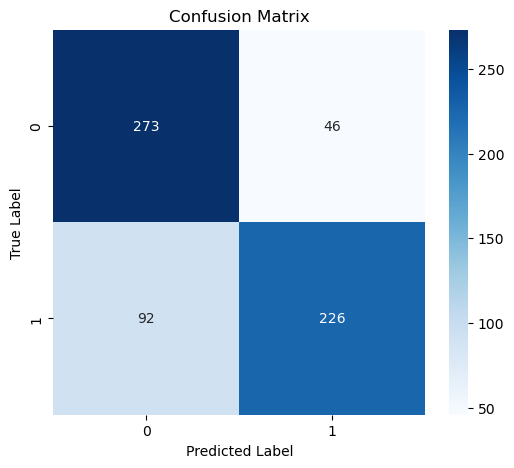

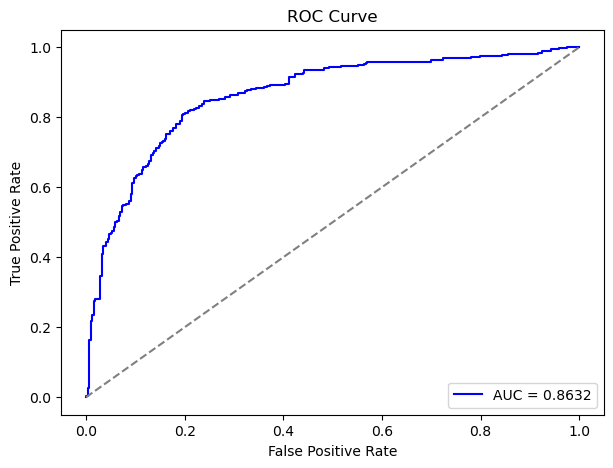

In [37]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model
model = load_model("ann_model1.h5")
print("Model loaded successfully!")

# Use the loaded model for predictions
y_preds_proba = model.predict(X_test)  # Get predicted probabilities
y_preds = np.round(y_preds_proba)  # Convert to binary predictions (0 or 1)

# Compute accuracy
accuracy = accuracy_score(y_test, y_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute ROC AUC score
auc_score = roc_auc_score(y_test, y_preds_proba)
print(f"ROC AUC Score: {auc_score:.4f}")

# Print classification report
print("Classification Report: \n", classification_report(y_test, y_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_preds_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


# Load Data for OverSampling

In [39]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
df = pd.read_csv("carsh_mod_grouped.csv")
df

,COUNTY,LIGHT,WEATHER,ROAD_COND,SURFACE_COND,RELATION_TO_JUNCTI,INTER_TYPE,MANNER_OF_COLL,ROAD_GEOM,LATITUDE,...,OP_AGE_D1,OP_SEX_D1,ALCOHOL_DRUG_DESCR_D1,CONTRIB_FACT_DESCR_D1,SPEED_LIMIT_D1,OP_AGE_D2,OP_SEX_D2,SPEED_LIMIT_D2,CRASH_HOUR,CRASH_SEVERITY
0,8,1,1,1,2.0,2,3,10,1,46.805305,...,0,1,0,6,0,2,0,0,0,5
1,45,2,2,1,2.0,2,3,2,1,46.905032,...,0,1,0,7,1,3,1,1,3,3
2,18,1,1,1,2.0,2,3,10,1,47.903942,...,1,0,0,6,0,0,0,0,0,3
3,9,2,1,1,1.0,1,1,2,1,46.861906,...,0,0,0,0,1,1,1,1,0,3
4,9,1,1,1,2.0,2,1,2,1,46.872620,...,0,1,0,5,1,1,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7359,9,1,1,1,2.0,2,1,1,2,46.818487,...,0,0,0,7,0,2,0,0,2,3
7360,45,1,1,1,1.0,1,1,2,1,46.879130,...,0,0,0,5,0,3,0,0,2,3
7361,53,2,1,1,1.0,2,3,1,1,48.160163,...,0,0,0,2,1,2,0,1,0,3
7362,51,1,1,1,2.0,2,1,1,1,48.221896,...,0,0,0,6,0,0,1,1,3,3


## Severity Mapping

In [42]:
# Define the mapping for CRASH_SEVERITY categories
severity_mapping = {
    3: 1,  # Change category 3 to 1
    2: 2,  # Keep category 2 the same
    4: 3,  # Change category 4 to 3
    5: 3,  # Change category 5 to 3
    1: 4   # Change category 1 to 5
}

# Apply the mapping to the CRASH_SEVERITY column
df['CRASH_SEVERITY'] = df['CRASH_SEVERITY'].map(severity_mapping)

# Verify the changes
print(df['CRASH_SEVERITY'].value_counts())


CRASH_SEVERITY
1    5772
3    1034
2     551
4       7
Name: count, dtype: int64


In [43]:
# Define the mapping for CRASH_SEVERITY categories
severity_mapping = {
    1: 0,  # Change category 3 to 1
    2: 1,  # Keep category 2 the same
    3: 1,  # Change category 4 to 3
    4: 1,  # Change category 5 to 3

}

# Apply the mapping to the CRASH_SEVERITY column
df['CRASH_SEVERITY'] = df['CRASH_SEVERITY'].map(severity_mapping)

# Verify the changes
print(df['CRASH_SEVERITY'].value_counts())


CRASH_SEVERITY
0    5772
1    1592
Name: count, dtype: int64


In [44]:
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming 'df' is your dataset and 'CRASH_SEVERITY' is the target variable
X = df.drop(columns=['CRASH_SEVERITY'])  # Features
y = df['CRASH_SEVERITY']  # Target variable

# Splitting before oversampling to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convert back to DataFrame for better interpretability
balanced_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
balanced_df['CRASH_SEVERITY'] = y_train_resampled

# Verify the new class distribution
print(balanced_df['CRASH_SEVERITY'].value_counts())

# Check the shape of the balanced dataset
balanced_df.shape


CRASH_SEVERITY
0    4617
1    4617
Name: count, dtype: int64


(9234, 28)

In [45]:
df = balanced_df.copy()

In [46]:
# Assuming 'df' is your dataset and 'CRASH_SEVERITY' is the target variable
X = df.drop(columns=['CRASH_SEVERITY'])  # Features
y = df['CRASH_SEVERITY']

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Tuned ML2

### LR

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       924
           1       0.63      0.67      0.65       923

    accuracy                           0.64      1847
   macro avg       0.64      0.64      0.64      1847
weighted avg       0.64      0.64      0.64      1847



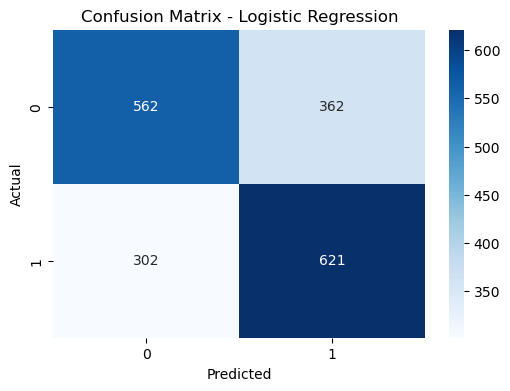

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Define hyperparameter grid
lr_params = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'lbfgs']
}

# Initialize model
lr = LogisticRegression(max_iter=5000, random_state=42)

# Perform Randomized Search CV
lr_search = RandomizedSearchCV(lr, lr_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
lr_search.fit(X_train, y_train)

# Best model
best_lr = lr_search.best_estimator_

# Predictions
y_pred_lr = best_lr.predict(X_test)

# Evaluate
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


ROC AUC Score: 0.69


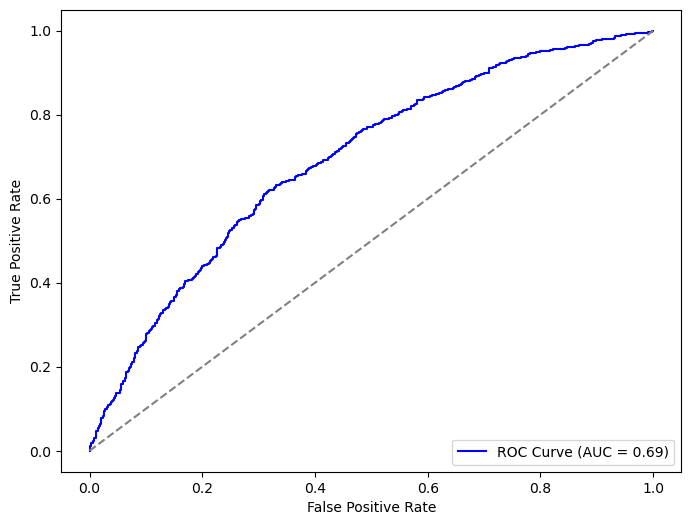

In [51]:

from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### RF

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       924
           1       0.81      0.81      0.81       923

    accuracy                           0.81      1847
   macro avg       0.81      0.81      0.81      1847
weighted avg       0.81      0.81      0.81      1847



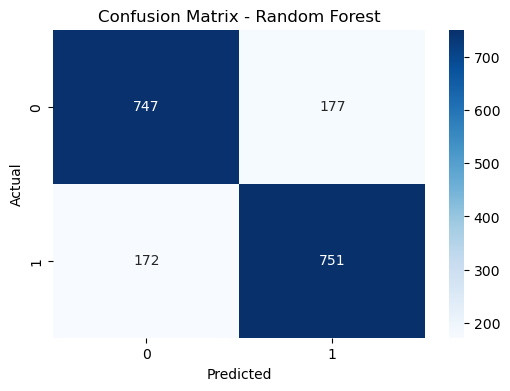

In [53]:
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid
rf_params = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Perform Randomized Search CV
rf_search = RandomizedSearchCV(rf, rf_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

# Best model
best_rf = rf_search.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test)

# Evaluate
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


ROC AUC Score: 0.89


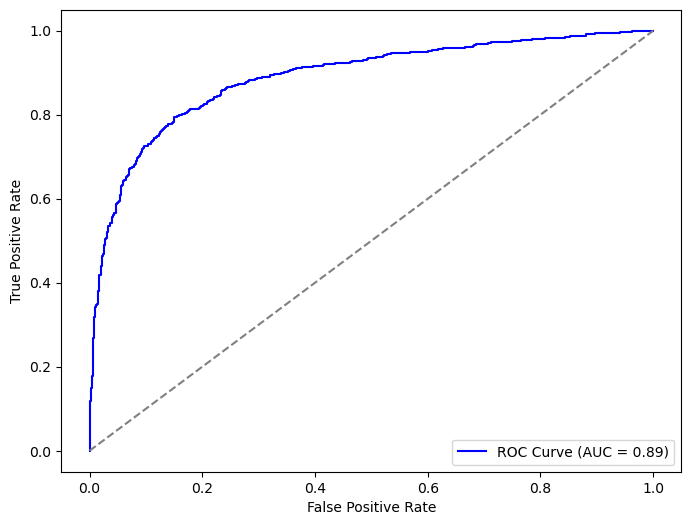

In [54]:

from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class
y_prob_lr = best_rf.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### MLP

MLP Performance:
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       924
           1       0.66      0.70      0.68       923

    accuracy                           0.67      1847
   macro avg       0.67      0.67      0.67      1847
weighted avg       0.67      0.67      0.67      1847



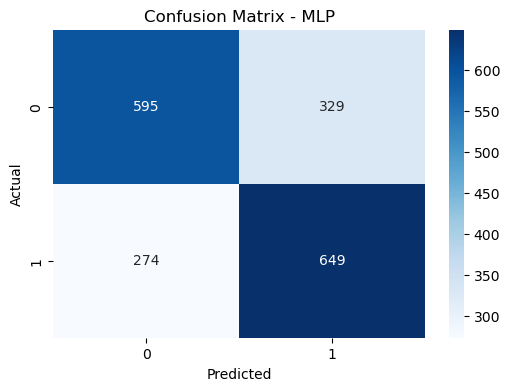

In [56]:
from sklearn.neural_network import MLPClassifier

# Define hyperparameter grid
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Initialize model
mlp = MLPClassifier(max_iter=1000, random_state=42)

# Perform Randomized Search CV
mlp_search = RandomizedSearchCV(mlp, mlp_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
mlp_search.fit(X_train, y_train)

# Best model
best_mlp = mlp_search.best_estimator_

# Predictions
y_pred_mlp = best_mlp.predict(X_test)

# Evaluate
print("MLP Performance:")
print(classification_report(y_test, y_pred_mlp))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MLP")
plt.show()


ROC AUC Score: 0.74


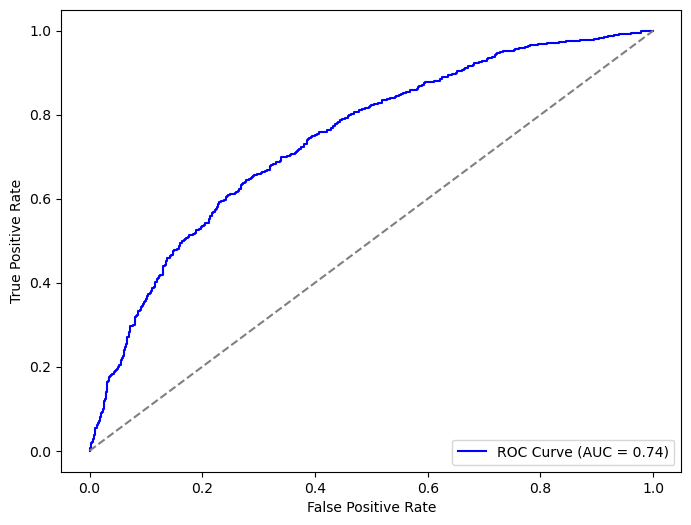

In [57]:

from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class
y_prob_lr = best_mlp.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### GB

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       924
           1       0.82      0.82      0.82       923

    accuracy                           0.82      1847
   macro avg       0.82      0.82      0.82      1847
weighted avg       0.82      0.82      0.82      1847



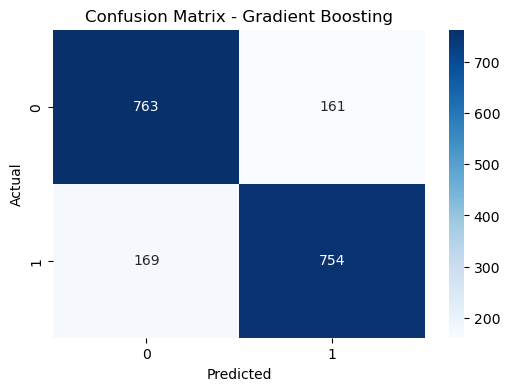

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

# Define hyperparameter grid
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

# Initialize model
gb = GradientBoostingClassifier(random_state=42)

# Perform Randomized Search CV
gb_search = RandomizedSearchCV(gb, gb_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
gb_search.fit(X_train, y_train)

# Best model
best_gb = gb_search.best_estimator_

# Predictions
y_pred_gb = best_gb.predict(X_test)

# Evaluate
print("Gradient Boosting Performance:")
print(classification_report(y_test, y_pred_gb))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


ROC AUC Score: 0.90


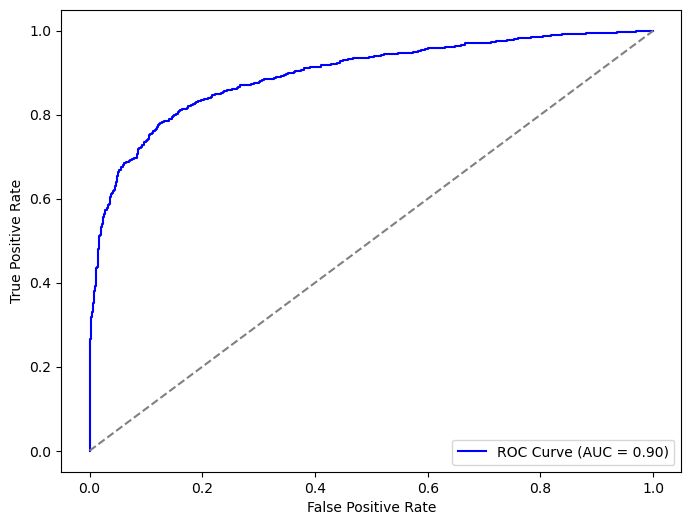

In [60]:

from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class
y_prob_lr = best_gb.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### KNN

KNN Performance:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       924
           1       0.73      0.90      0.81       923

    accuracy                           0.79      1847
   macro avg       0.81      0.79      0.79      1847
weighted avg       0.81      0.79      0.79      1847



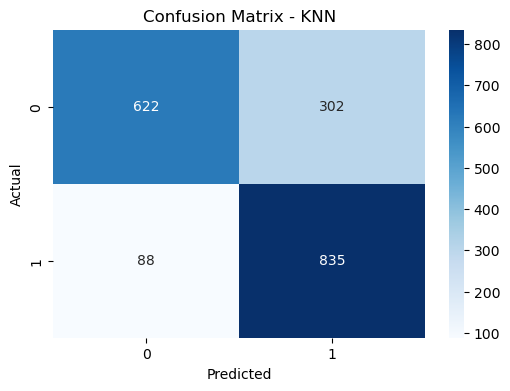

In [62]:
from sklearn.neighbors import KNeighborsClassifier

# Define hyperparameter grid
knn_params = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize model
knn = KNeighborsClassifier()

# Perform Randomized Search CV
knn_search = RandomizedSearchCV(knn, knn_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
knn_search.fit(X_train, y_train)

# Best model
best_knn = knn_search.best_estimator_

# Predictions
y_pred_knn = best_knn.predict(X_test)

# Evaluate
print("KNN Performance:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN")
plt.show()


ROC AUC Score: 0.79


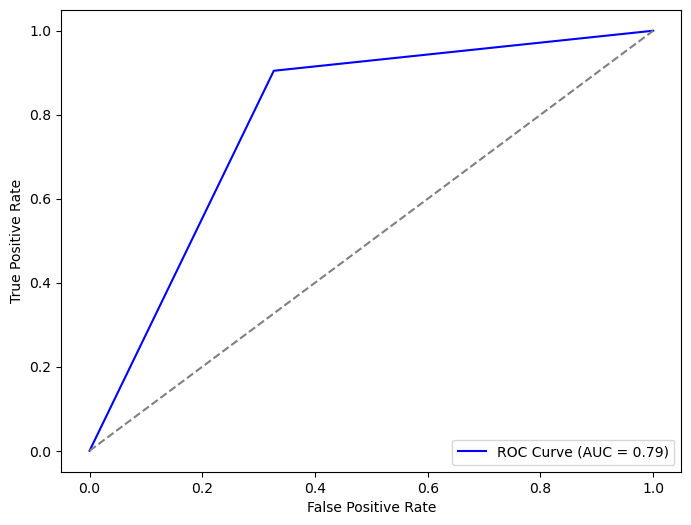

In [63]:

from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class
y_prob_lr = best_knn.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### Parameters

In [65]:
print("Best Parameters for Logistic Regression:", lr_search.best_params_)
print("Best Parameters for Random Forest:", rf_search.best_params_)
print("Best Parameters for MLP:", mlp_search.best_params_)
print("Best Parameters for Gradient Boosting:", gb_search.best_params_)
print("Best Parameters for KNN:", knn_search.best_params_)


Best Parameters for Logistic Regression: {'solver': 'lbfgs', 'C': 3792.690190732246}
Best Parameters for Random Forest: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Best Parameters for MLP: {'solver': 'adam', 'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'activation': 'tanh'}
Best Parameters for Gradient Boosting: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1}
Best Parameters for KNN: {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'euclidean'}


### Hybrid


Combination 130
Base Models: logistic, random_forest, gradient_boosting, knn
Meta Model: mlp
Accuracy: 0.8213
F1-score: 0.8350
ROC AUC: 0.9182

Detailed Classification Report:
              precision    recall  f1-score      support
0              0.885714  0.738095  0.805195   924.000000
1              0.775302  0.904659  0.835000   923.000000
accuracy       0.821332  0.821332  0.821332     0.821332
macro avg      0.830508  0.821377  0.820097  1847.000000
weighted avg   0.830538  0.821332  0.820089  1847.000000



Combination 126
Base Models: logistic, random_forest, gradient_boosting, knn
Meta Model: logistic
Accuracy: 0.8192
F1-score: 0.8320
ROC AUC: 0.9155

Detailed Classification Report:
              precision    recall  f1-score      support
0              0.877238  0.742424  0.804220   924.000000
1              0.776526  0.895991  0.831992   923.000000
accuracy       0.819166  0.819166  0.819166     0.819166
macro avg      0.826882  0.819208  0.818106  1847.000000
weighted avg

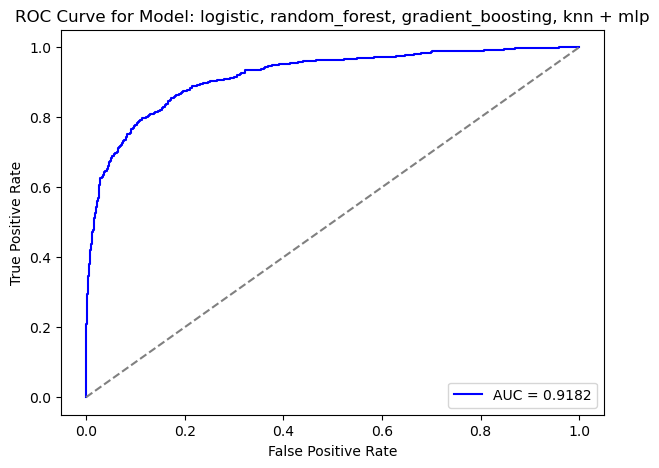

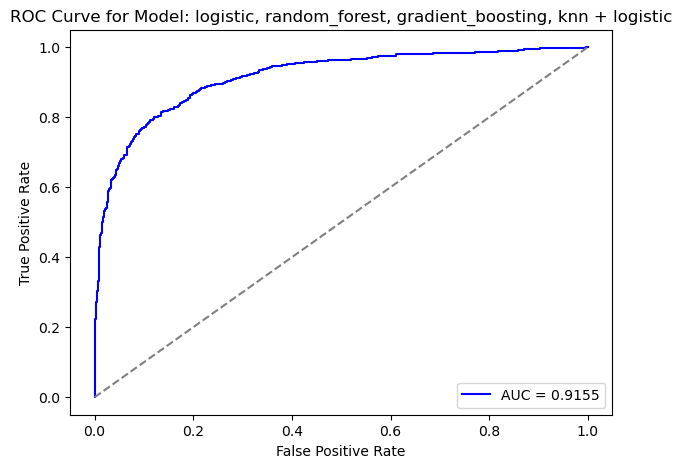

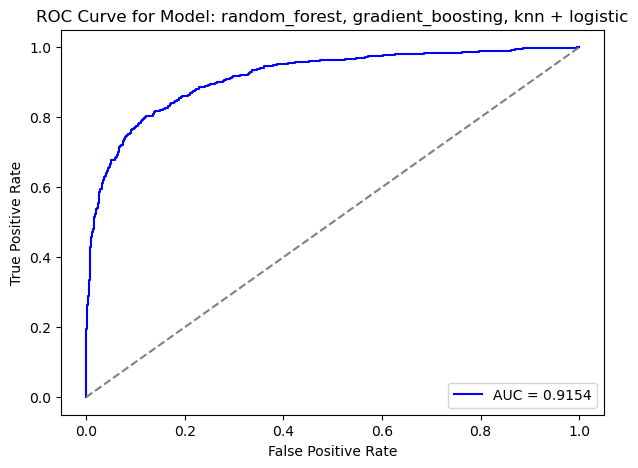

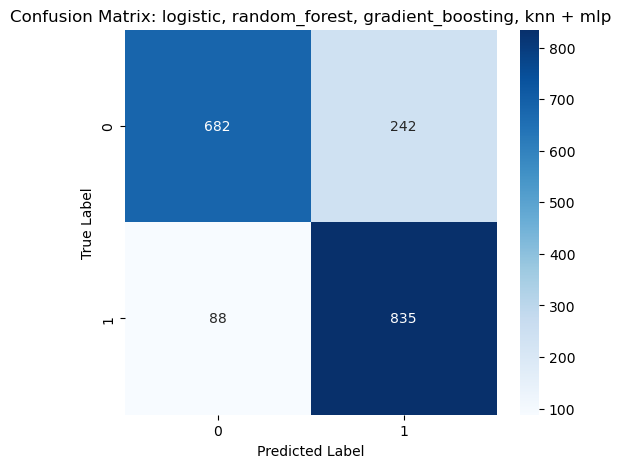

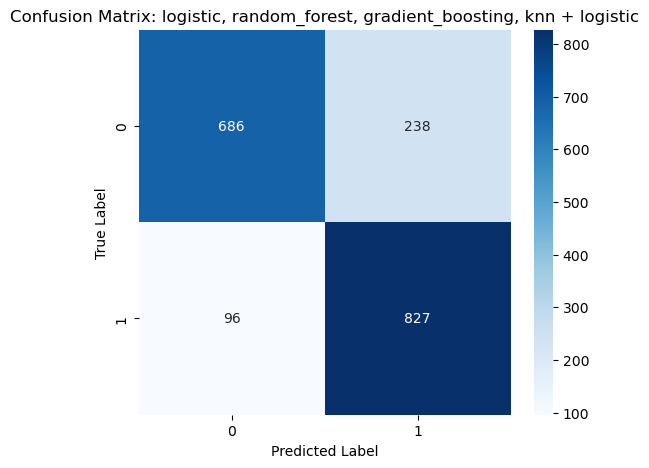

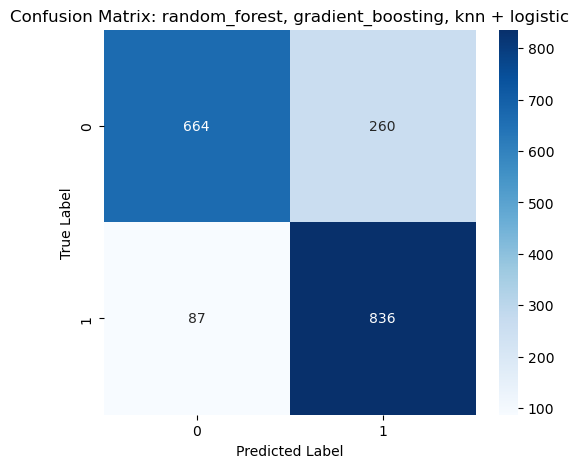

In [67]:
import sys
sys.path.append('/content/drive/MyDrive/Projects/tRANSPORT/Ashik Bhai/Code and Models')

from stacking_combination2 import BinaryStackingClassifierExperiment

# Suppose you already have your trained base models and meta models:
trained_models = {
    'logistic': best_lr,
    'random_forest': best_rf,
    'gradient_boosting': best_gb,
    'knn': best_knn,
    'mlp': best_mlp
}

meta_models = {
    'logistic': LogisticRegression(max_iter=5000, random_state=42),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'rf': RandomForestClassifier(n_estimators=100, random_state=42),
    'gb': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'mlp': MLPClassifier(hidden_layer_sizes=(100,), max_iter=5000, random_state=42)
}



experiment = BinaryStackingClassifierExperiment(trained_models, meta_models, verbose=False)



# Run your experiment
results_df = experiment.run_experiment(X_train, y_train, X_test, y_test)


# experiment.plot_top_results(top_n=5)
experiment.print_detailed_results(top_n=3)
experiment.plot_individual_roc_curves (top_n=3)
# Plot Confusion Matrices for top 3 models
experiment.plot_individual_confusion_matrices(top_n=3)

### ANN

In [70]:

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix , classification_report

Model loaded successfully!
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.7179
ROC AUC Score: 0.7922
Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.74      0.72       924
           1       0.73      0.70      0.71       923

    accuracy                           0.72      1847
   macro avg       0.72      0.72      0.72      1847
weighted avg       0.72      0.72      0.72      1847



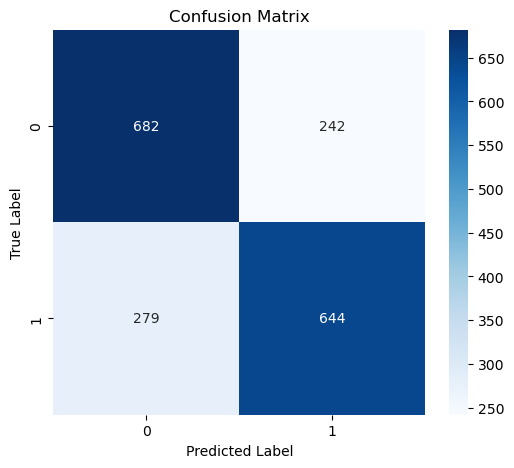

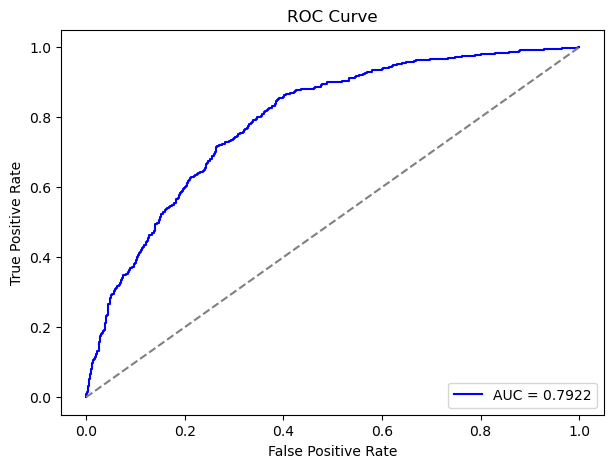

In [122]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model
model = load_model("ann_model2.h5")
print("Model loaded successfully!")

# Use the loaded model for predictions
y_preds_proba = model.predict(X_test)  # Get predicted probabilities
y_preds = np.round(y_preds_proba)  # Convert to binary predictions (0 or 1)

# Compute accuracy
accuracy = accuracy_score(y_test, y_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute ROC AUC score
auc_score = roc_auc_score(y_test, y_preds_proba)
print(f"ROC AUC Score: {auc_score:.4f}")

# Print classification report
print("Classification Report: \n", classification_report(y_test, y_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_preds_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
